<div style="text-align:center;">
    <img width="200px" height="200px" src="./pics/Logo.png"></img>
    <br>
    <div style="font-size: 30px; color: #ff6600; font-weight: bold">
        Long Short-Term Memory (LSTM)
    </div>
    <div style="font-size: 20px; color: #ff6600; font-weight: bold">
         Computational Intelligence
    </div>
    <br>
    <div style="font-size: 18px; color: #555;">
        <strong>Dr. Mozayani</strong>
    </div>
    <div style="font-size: 18px; color: #555;">
        <strong>Fall 2025</strong>
    </div>
</div>


Name: Daryoush Safe Ashrafi\
ID: 401521336

In this notebook, we will build and train an LSTM model to predict the stock market.
<span style="color:red; font-weight: bold">You are not allowed to use TensorFlow or Keras libraries.</span>

<div style="font-size: 25px; color: #ff6600; font-weight: bold">
1. Libraries and settings
</div>


In [60]:
# Import libraries
# Notice that it is important that which libraries you use, so you should import
# libraries just here in your code

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


<div style="font-size: 25px; color: #ff6600; font-weight: bold">
2. Load data
</div>


In [61]:
# Read data
df = pd.read_csv('NVDA.csv')
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.NVDA,D,20101004,0,11.24,11.430,11.01,11.23,18184874
1,US1.NVDA,D,20101005,0,11.48,11.500,11.29,11.32,18266877
2,US1.NVDA,D,20101006,0,11.32,11.370,10.67,10.78,25753399
3,US1.NVDA,D,20101007,0,10.82,10.840,10.38,10.70,18732301
4,US1.NVDA,D,20101008,0,10.65,10.950,10.51,10.86,16998198
...,...,...,...,...,...,...,...,...,...
2762,US1.NVDA,D,20210927,0,217.16,217.750,213.28,216.57,625939
2763,US1.NVDA,D,20210928,0,212.01,214.030,206.51,207.02,835341
2764,US1.NVDA,D,20210929,0,209.33,210.160,204.68,205.22,606902
2765,US1.NVDA,D,20210930,0,207.89,210.650,206.89,207.12,537697


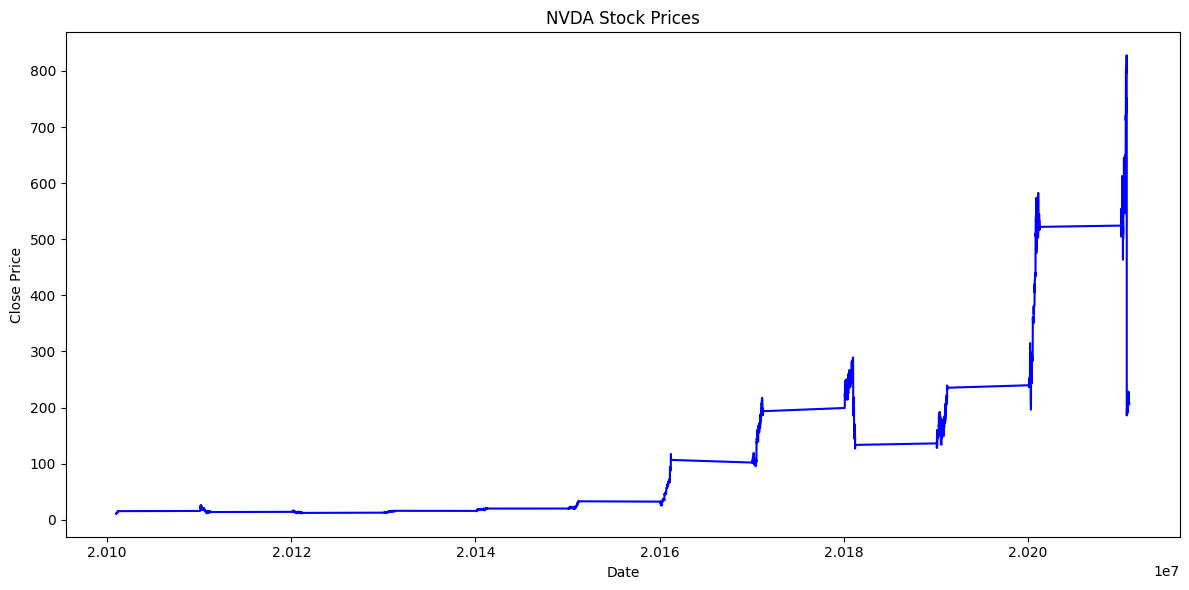

In [62]:
# Plot close prices ("<CLOSE>") based on dates ("<DATE>")

#####################

plt.figure(figsize=(12, 6))
plt.plot(df['<DATE>'], df['<CLOSE>'], color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('NVDA Stock Prices')
plt.tight_layout()
plt.show()

#####################

In [63]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2166, 59, 9)
y_train.shape =  (2166, 9)
x_test.shape =  (541, 59, 9)
y_test.shape =  (541, 9)


In [64]:
x_train = x_train[:, :, 7]
x_test  = x_test[:, :, 7]
y_train = y_train[:, 7]
y_test  = y_test[:, 7]

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2166, 59)
y_train.shape =  (2166,)
x_test.shape =  (541, 59)
y_test.shape =  (541,)


In [65]:

y_test_original = y_test.copy()
y_train_original = y_train.copy()

scaler = MinMaxScaler()

all_train_prices = np.concatenate([x_train.reshape(-1, 1), y_train.reshape(-1, 1)])
scaler.fit(all_train_prices)

x_train_scaled = scaler.transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 1)).reshape(x_test.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

x_train = torch.from_numpy(x_train_scaled).float()
y_train = torch.from_numpy(y_train_scaled).float()
x_test = torch.from_numpy(x_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test_scaled).float()

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [66]:
# x_train_scaled = x_train.reshape(-1, 1).reshape(x_train.shape)
# x_test_scaled = x_test.reshape(-1, 1).reshape(x_test.shape)
# y_train_scaled = y_train.reshape(-1, 1).flatten()
# y_test_scaled = y_test.reshape(-1, 1).flatten()

# x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
# x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

# x_train = torch.from_numpy(x_train_scaled).float()
# y_train = torch.from_numpy(y_train_scaled).float()
# x_test = torch.from_numpy(x_test_scaled).float()
# y_test_tensor = torch.from_numpy(y_test_scaled).float()

# train_dataset = TensorDataset(x_train, y_train)
# test_dataset = TensorDataset(x_test, y_test_tensor)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

<div style="font-size: 25px; color: #ff6600; font-weight: bold">
3. Build the structure of models
</div>


In [67]:
# Build model
#####################
# Here we define our model as a class (i tested dropout layer too)
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.0):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

    def backward(self):
      ################
      pass
      ################


# you can change these parameters to get better result
input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
dropout = 0.3
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout=dropout)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [68]:
# Train models

#####################
epochs = 40
train_loss_pool = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_pool.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")
#####################

Epoch 1/40, Train Loss: 0.1138
Epoch 2/40, Train Loss: 0.0974
Epoch 3/40, Train Loss: 0.0890
Epoch 4/40, Train Loss: 0.0847
Epoch 5/40, Train Loss: 0.0825
Epoch 6/40, Train Loss: 0.0812
Epoch 7/40, Train Loss: 0.0779
Epoch 8/40, Train Loss: 0.0725
Epoch 9/40, Train Loss: 0.0624
Epoch 10/40, Train Loss: 0.0363
Epoch 11/40, Train Loss: 0.0379
Epoch 12/40, Train Loss: 0.0603
Epoch 13/40, Train Loss: 0.0294
Epoch 14/40, Train Loss: 0.0135
Epoch 15/40, Train Loss: 0.0104
Epoch 16/40, Train Loss: 0.0080
Epoch 17/40, Train Loss: 0.0069
Epoch 18/40, Train Loss: 0.0061
Epoch 19/40, Train Loss: 0.0057
Epoch 20/40, Train Loss: 0.0051
Epoch 21/40, Train Loss: 0.0055
Epoch 22/40, Train Loss: 0.0041
Epoch 23/40, Train Loss: 0.0050
Epoch 24/40, Train Loss: 0.0042
Epoch 25/40, Train Loss: 0.0047
Epoch 26/40, Train Loss: 0.0039
Epoch 27/40, Train Loss: 0.0042
Epoch 28/40, Train Loss: 0.0036
Epoch 29/40, Train Loss: 0.0038
Epoch 30/40, Train Loss: 0.0032
Epoch 31/40, Train Loss: 0.0034
Epoch 32/40, Trai

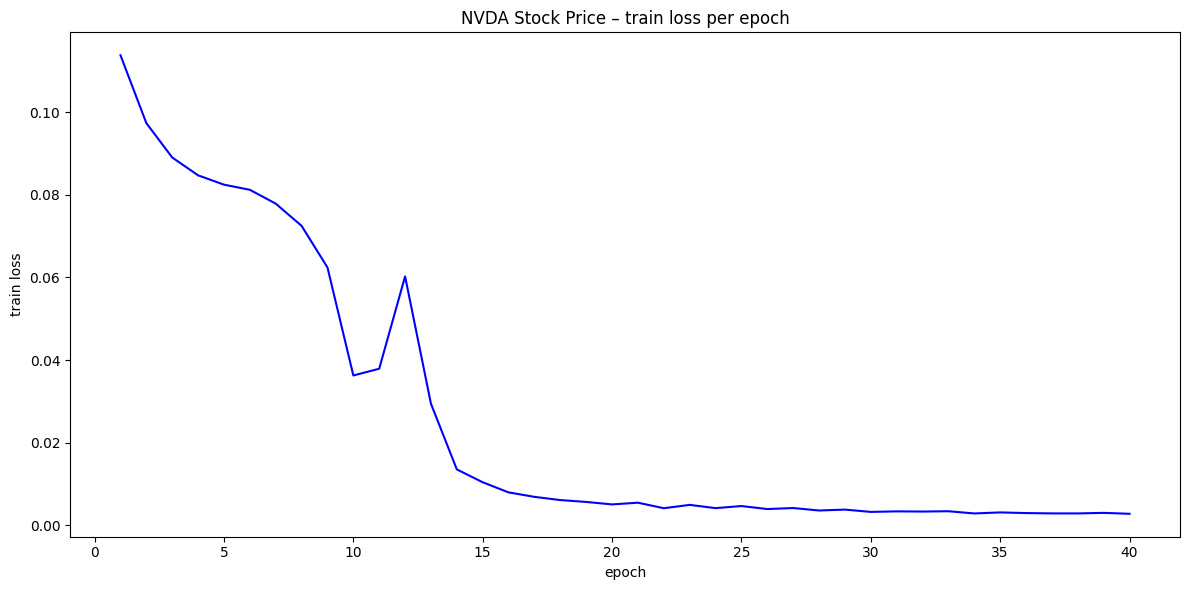

In [69]:
# Plot loss based on epochs

#####################
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 41), train_loss_pool, label='Actual', color='blue')
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title('NVDA Stock Price – train loss per epoch')
plt.tight_layout()
plt.show()
#####################

In [70]:
model.eval()
with torch.no_grad():
    predictions_scaled = model(x_test.to(device)).cpu().numpy()

    predictions = scaler.inverse_transform(predictions_scaled)

    rmse = np.sqrt(np.mean((predictions.flatten() - y_test_original)**2))
    print(f"\nTest RMSE (original scale): {rmse:.2f}")

    rmse_normalized = np.sqrt(np.mean((predictions_scaled.flatten() - y_test_scaled)**2))
    print(f"Test RMSE (normalized scale): {rmse_normalized:.6f}")



Test RMSE (original scale): 183.04
Test RMSE (normalized scale): 0.656841


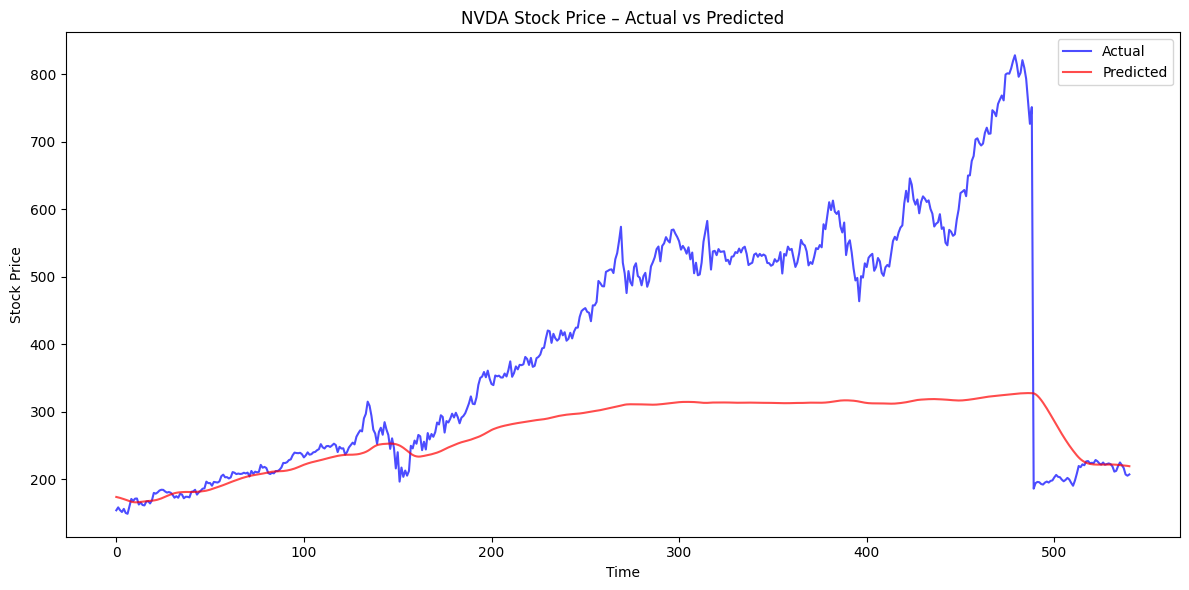

In [71]:
# Visualising the prediction results

#####################

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual', color='blue', alpha=0.7)
plt.plot(predictions.flatten(), label='Predicted', color='red', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('NVDA Stock Price – Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

#####################

In [72]:
model.eval()
with torch.no_grad():
    predictions_scaled_train = model(x_train.to(device)).cpu().numpy()

    predictions_train = scaler.inverse_transform(predictions_scaled_train)

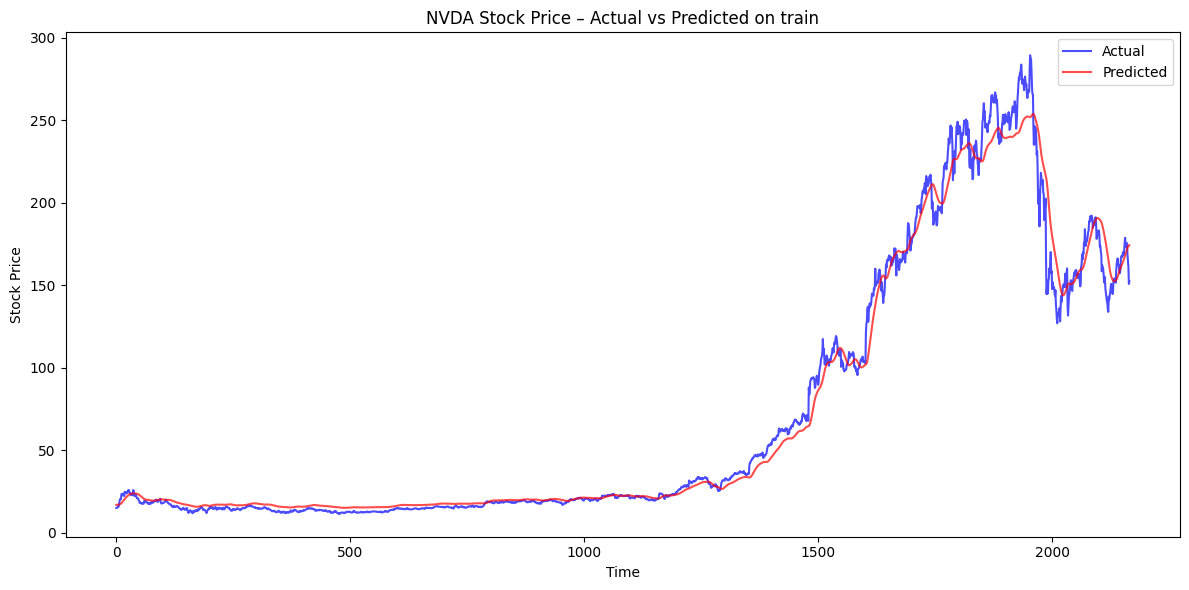

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(y_train_original, label='Actual', color='blue', alpha=0.7)
plt.plot(predictions_train.flatten(), label='Predicted', color='red', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('NVDA Stock Price – Actual vs Predicted on train')
plt.legend()
plt.tight_layout()
plt.show()

<div  style="font-size: 17px; line-height: 150%">
    <div style="font-size: 25px; color: #ff6600; font-weight: bold">
       4. Comparison of Model Prediction Performance
    </div>
      In this section, you will compare the prediction performance of the provided LSTM model with that of pre-built models. The goal is to evaluate how well the given implementation captures the underlying patterns in the data compared to standard implementations.
      <span style="color:green">You are allowed to use deep learning libraries to build and train the comparison model, and you may choose either TensorFlow or PyTorch for implementing the pre-built LSTM.</span>
</div>

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Keras Model...
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


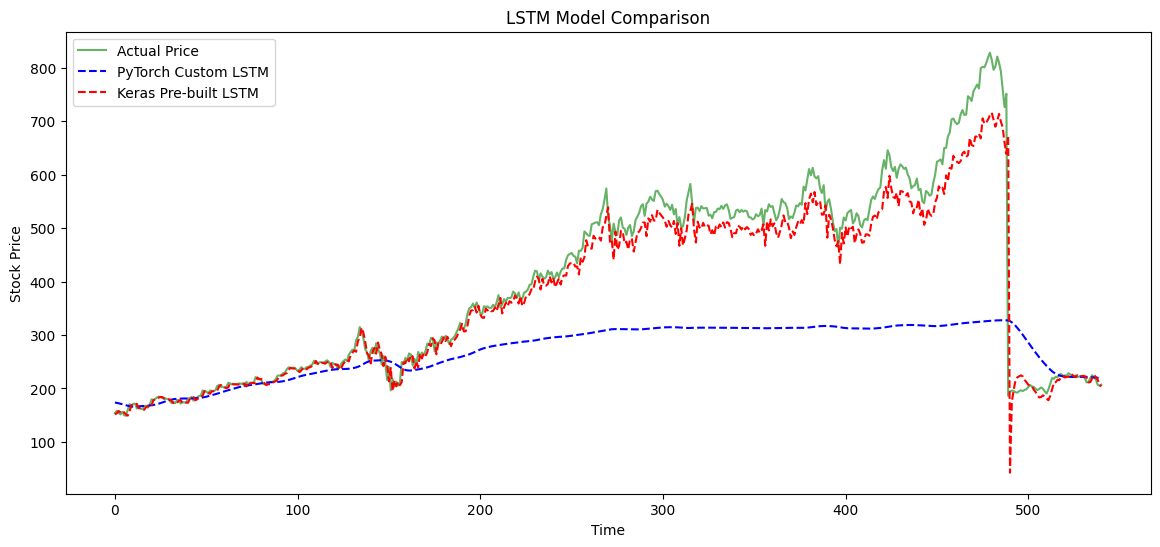

In [74]:
# === Comparison ===
# Compute and print error metrics (e.g., MSE, RMSE) for both models,
# and visualize their predictions on the same plot.

#####################
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


model_keras = Sequential()
model_keras.add(LSTM(units=hidden_dim, return_sequences=True, input_shape=(look_back, 1)))
model_keras.add(LSTM(units=hidden_dim, return_sequences=False))
model_keras.add(Dense(units=output_dim))

model_keras.compile(optimizer='adam', loss='mean_squared_error')

print("Training Keras Model...")
history_keras = model_keras.fit(x_train, y_train, epochs=40, batch_size=16, verbose=0)

pred_keras = model_keras.predict(x_test)
predicted_keras = scaler.inverse_transform(pred_keras)

mse_keras = np.mean((predicted_keras - y_test_original) ** 2)

plt.figure(figsize=(14, 6))
plt.plot(y_test_original, label='Actual Price', color='green', alpha=0.6)
plt.plot(predictions, label='PyTorch Custom LSTM', color='blue', linestyle='--')
plt.plot(predicted_keras, label='Keras Pre-built LSTM', color='red', linestyle='--')
plt.title('LSTM Model Comparison')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
#####################


This Keras model is just copying the last frames!

<div  style="font-size: 17px; line-height: 150%">
    <div style="font-size: 25px; color: #ff6600; font-weight: bold">
        Bonus (5%)
    </div>
     try denoising techniques and train models again after denoising the prices. Then compare the results with previous step and explain  how much improvment you can make by denoising data.
</div>